# CS 20 : TensorFlow for Deep Learning Research
## Lecture 03 : Linear and Logistic Regression
### Logistic Regression with tf.data
same contents, but different style with [Lec03_Logistic Regression with tf.data.ipynb](https://nbviewer.jupyter.org/github/aisolab/CS20/blob/master/Lec03_Linear%20and%20Logistic%20Regression/Lec03_Logistic%20Regression%20with%20tf.data.ipynb)

* Creating the input pipeline with `tf.data`
* Using `eager execution`  

### Setup

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

print(tf.__version__)
tf.enable_eager_execution()

1.12.0


### Load and Pre-process data

In [2]:
(x_train, y_train), (x_tst, y_tst) = tf.keras.datasets.mnist.load_data()
x_train = (x_train  / 255)
x_train = x_train.reshape(-1, 784).astype(np.float32)
x_tst = (x_tst / 255)
x_tst = x_tst.reshape(-1, 784).astype(np.float32)

y_train = y_train.astype(np.int32)
y_tst = y_tst.astype(np.int32)

In [3]:
tr_indices = np.random.choice(range(x_train.shape[0]), size = 55000, replace = False)

x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices]

x_val = np.delete(arr = x_train, obj = tr_indices, axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices, axis = 0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(55000, 784) (55000,)
(5000, 784) (5000,)


### Define the graph of Softmax Classifier

In [4]:
# hyper-par setting
epochs = 30
batch_size = 64

In [5]:
# for train
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
tr_dataset = tr_dataset.shuffle(buffer_size = 10000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)

# for validation
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_dataset = val_dataset.batch(batch_size = batch_size)

In [6]:
# create weight and bias, initialized to 0 
w = tf.Variable(initial_value=tf.random_normal(shape=[784,10],
                                               stddev=np.sqrt(2. / (784 + 10)).astype(np.float32)), name='weights')
b = tf.Variable(initial_value=tf.zeros(shape = [10], ), name='bias')

# construct model
def model(x):
    score = tf.matmul(x, w) + b
    return score
    
# use the cross entropy as loss function
def loss_fn(model, x, y):
    ce_loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=y, logits=model(x)))
    return ce_loss

# using gradient descent with learning rate of 0.01 to minimize loss
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)

### Training

In [7]:
# create writer for tensorboard
logdir = '../graphs/lecture03/logreg_tf_data_de/'
summary_writer = tf.contrib.summary.create_file_writer(logdir=logdir)

In [8]:
#epochs = 30
#batch_size = 64
#total_step = int(x_tr.shape[0] / batch_size)

tr_loss_hist = []
val_loss_hist = []
tf.GradientTape.gradient
for epoch in range(epochs):

    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    # for training
    with summary_writer.as_default(), tf.contrib.summary.always_record_summaries(): # for tensorboard
        for x_mb, y_mb in tr_dataset:
            with tf.GradientTape() as tape:
                tr_loss = loss_fn(model=model, x=x_mb, y=y_mb)
            tf.contrib.summary.scalar(name='tr_loss', tensor=tr_loss)
            avg_tr_loss += tr_loss
            tr_step += 1
            grads = tape.gradient(target=tr_loss, sources=[w, b])
            opt.apply_gradients(grads_and_vars=zip(grads, [w, b]))
        else:
            avg_tr_loss /= tr_step
            tr_loss_hist.append(avg_tr_loss)
    
    
        # for validation
        for x_mb, y_mb in val_dataset:
            val_loss = loss_fn(model=model, x=x_mb, y=y_mb)
            tf.contrib.summary.scalar(name='val_loss', tensor=val_loss)
            avg_val_loss += val_loss
            val_step += 1
        else:
            avg_val_loss /= val_step
            val_loss_hist.append(avg_val_loss)
            
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))

epoch :   5, tr_loss : 0.421, val_loss : 0.408
epoch :  10, tr_loss : 0.363, val_loss : 0.353
epoch :  15, tr_loss : 0.339, val_loss : 0.330
epoch :  20, tr_loss : 0.325, val_loss : 0.318
epoch :  25, tr_loss : 0.315, val_loss : 0.308
epoch :  30, tr_loss : 0.308, val_loss : 0.302


### Visualization

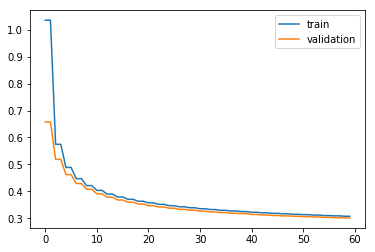

In [9]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

In [10]:
yhat = np.argmax(model(x_tst), axis = 1)
print('acc : {:.2%}'.format(np.mean(yhat == y_tst)))

acc : 91.88%
